<a href="https://colab.research.google.com/github/piccoripico/etc/blob/master/Whisper_v3_(share).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使い方


1.   文字起こししたいファイルを用意する（音声ファイル又は動画ファイル）
2.   実行ボタンをクリック（左下のこのボタン→）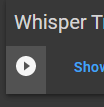
1.   ファイルをアップロード（実行後に下部に表示されるボタンから）
2.   txtファイルが出力されるまで待つ（90分のファイルなら10分程度？）


*   複数ファイル一括アップロード可
*   GoogleDriveFilesフラグ　直接アップロードする代わりにGoogleDriveのファイルを文字起こしする（ファイルパスは手入力）
*   isJapaneseLanguageフラグ　言語を日本語に指定（チェックなしの場合は自動判定）
*   isTranslateIntoEnglish_NoOriginalFileフラグ　英語に翻訳（※翻訳後の英語しか出力されない）
*   isTimeフラグ　ダウンロードするtxtファイルに開始時刻情報を追加
*   isExcelフラグ　生データをエクセルファイルでダウンロード（txtファイルに加えて）
*   Google Colabの利用状況が重いか文字起こしの負荷をかけすぎると処理が止まるかも（CUDA out of memory error）→その場合は一旦Disconnectしてやり直し

In [ ]:
#@title Whisper Transcription

# GoogleDriveのファイルを使う or 直接アップロードする
GoogleDriveFiles = False #@param {type:"boolean"}

# GoogleDriveのファイルを使う場合（ファイルパスの手入力が必要）
if GoogleDriveFiles:
    # GoogleDriveをマウント
    from google.colab import drive, files
    drive.mount('/content/drive')

    #////////////////////////////////////////////////////#
    # /content/drive/MyDrive/～～のファイルパスを手入力
    meeting_file_paths = [
        "/content/drive/MyDrive/01.mp4",
        "/content/drive/MyDrive/02.mp4",
    ]
    #////////////////////////////////////////////////////#

# 直接アップロードする場合（アップロードする分の時間がかかる）
else:
    from google.colab import files
    import sys

    def upload_files():
        uploaded_files = files.upload()
        if not uploaded_files:
            print("No file was uploaded. Exiting the program.")
            sys.exit()
        return uploaded_files

    uploaded = upload_files()

    # アップロード先となるColab上のファイルパスを格納
    meeting_file_paths = []
    for meeting_file_name in uploaded.keys():
        meeting_file_path = "/content/" + meeting_file_name
        meeting_file_paths.append(meeting_file_path)

# https://huggingface.co/openai/whisper-large-v3

# pip installはColab上でセルを分けた方がプログラム的には良いが、
# 実行ボタン1回押した後は放置して処理したいためこの位置に記述
# フラグのファイルパスを設定
pip_flg = 'upgrades_done.flag'
# フラグファイルが存在しない場合にのみアップグレードを実行
import os
if not os.path.exists(pip_flg):
    !pip install --upgrade pip
    !pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio]
    # アップグレード後、フラグファイルを作成して次回の実行をスキップ
    with open(pip_flg, 'w') as f:
        f.write('Upgrades done')

import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

# ファイルパスごとに処理
for file_path in meeting_file_paths:
    # フラグ：日本語指定、英語翻訳
    isJapaneseLanguage = True #@param {type:"boolean"}
    isTranslateIntoEnglish_NoOriginalFile = False #@param {type:"boolean"}

    # フラグに応じてWhisperのパラメータを変更
    if isJapaneseLanguage == True & isTranslateIntoEnglish_NoOriginalFile == True:
        pipe_param_list = {'language': 'japanese', 'task': 'translate'}
    elif isTranslateIntoEnglish_NoOriginalFile == True:
        pipe_param_list = {'task': 'translate'}
    elif isJapaneseLanguage == True:
        pipe_param_list = {'language': 'japanese'}
    else:
        pipe_param_list = {}

    # Whisper実行
    transcribe = pipe(
        file_path,
        return_timestamps=True,
        generate_kwargs=pipe_param_list
    )

    # Whisper出力ファイルのリスト'chunks'の'text'ごとに改行
    # 開始時間情報フラグに応じ、txtファイルに開始時刻情報を加える
    transcript = ""
    isTime = True #@param {type:"boolean"}
    if isTime:
        import datetime
        for chunk in transcribe['chunks']:
            # 秒数を時間、分、秒に分解する
            start_time = chunk['timestamp'][0]
            hours, remainder = divmod(start_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            # datetimeオブジェクトを作成する
            chunk_time = datetime.time(hour=int(hours), minute=int(minutes), second=int(seconds))
            # 時刻の文字列を作成する
            chunk_time = chunk_time.strftime('%H:%M:%S')

            transcript += "[" + chunk_time + "] " + chunk['text'] + "\n"
    else:
        # 'chunks'の'text'のみ抽出
        for chunk in transcribe['chunks']:
            transcript += chunk['text'] + "\n"

    # txtファイルを作成してダウンロード
    meeting_text = file_path + '.txt'
    with open(meeting_text, 'w', encoding='utf-8') as f:
        f.writelines(transcript)
    files.download(meeting_text)

    # Excel形式でダウンロード
    # https://tech.briswell.com/entry/2022/09/28/192306
    # https://www.yutaka-note.com/entry/pandas_to_excel
    isExcel = True #@param {type:"boolean"}
    if isExcel:
        import pandas as pd
        # Whisper出力ファイルのリスト'chunks'をデータフレームに変換
        df = pd.DataFrame(transcribe["chunks"])
        # 'chunks'の'timestamp'リストを開始時刻と終了時刻に分割して追加
        df[['start_time', 'end_time']] = pd.DataFrame(df['timestamp'].tolist(), index=df.index)
        # （'timestamp'自体は削除）
        df = df.drop('timestamp', axis=1)
        # 列を並び替え
        df = df[['start_time', 'end_time', 'text']]
        # エクセルファイルに変換
        meeting_excel = file_path + '.xlsx'
        df.to_excel(meeting_excel, index=False)
        # ダウンロード
        files.download(meeting_excel)

    # （確認用）Colab上でプリント
    # print(transcribe)
    # print(transcript)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>